In [16]:
import pandas as pd
import numpy as np
from prophet import Prophet

start_date = '2019-01-01'
end_date = '2022-01-01'

dates = pd.date_range(start=start_date, end=end_date, freq='D')
unix_dates = np.array([int(pd.Timestamp(d).timestamp()) for d in dates])
# Recreate a DatetimeIndex with a specific frequency

freq = 'D'  # Monthly frequency
date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

prices = np.sin(unix_dates)

data = pd.DataFrame({'ds': date_rng, 'y': prices})

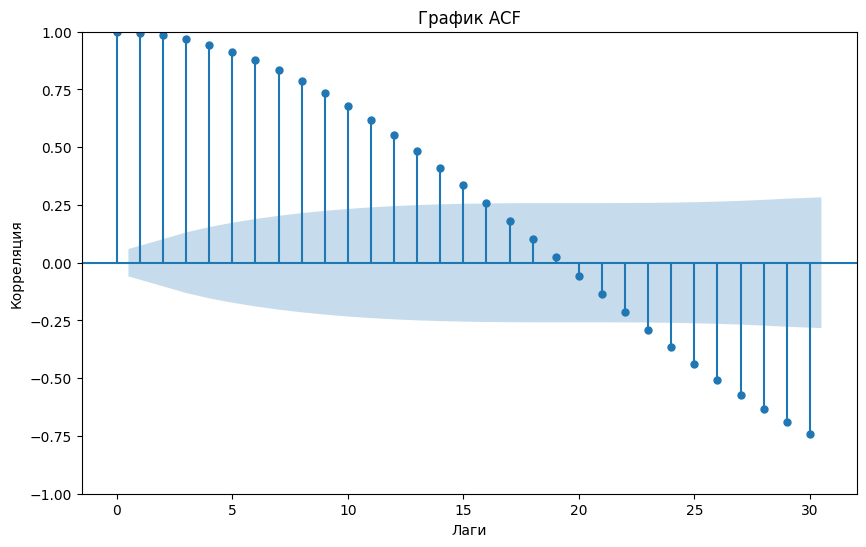

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


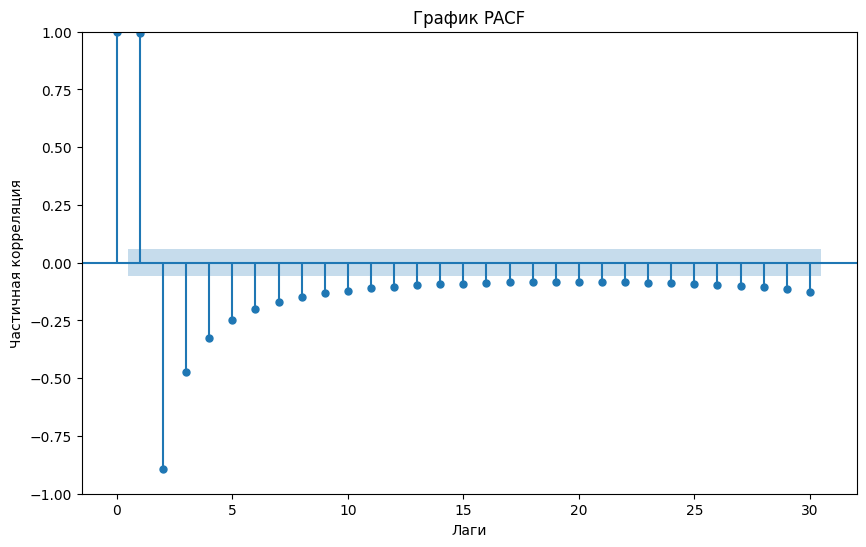

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
# Построение графика автокорреляционной функции (ACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.title('График ACF')
plt.show()
# Построение графика частичной автокорреляционной функции (PACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(prices, lags=30, ax=ax)  # Установите значение lags в соответствии с вашими потребностями
plt.xlabel('Лаги')
plt.ylabel('Частичная корреляция')
plt.title('График PACF')
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6590239738327134e+16
p-value: 0.0


In [19]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [20]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


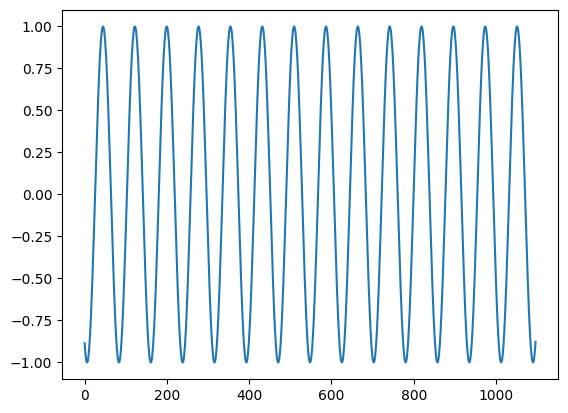

In [22]:
plt.plot(prices)

In [23]:
model_data = pd.DataFrame({'Price': prices, 'Date': date_rng})
model_data = model_data.set_index('Date', inplace = False)
model_data.head(10)

,Price
Date,
2019-01-01,-0.885371
2019-01-02,-0.920145
2019-01-03,-0.948861
2019-01-04,-0.971331
2019-01-05,-0.987407
2019-01-06,-0.996982
2019-01-07,-0.999994
2019-01-08,-0.996423
2019-01-09,-0.986292


In [24]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(model_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
val_size = 100
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [26]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Epoch [1/1100], Train Loss: 0.3193, Valid Loss: 0.3498
Epoch [11/1100], Train Loss: 0.1726, Valid Loss: 0.1830
Epoch [21/1100], Train Loss: 0.0819, Valid Loss: 0.0740
Epoch [31/1100], Train Loss: 0.0664, Valid Loss: 0.0639
Epoch [41/1100], Train Loss: 0.0484, Valid Loss: 0.0417
Epoch [51/1100], Train Loss: 0.0316, Valid Loss: 0.0292
Epoch [61/1100], Train Loss: 0.0170, Valid Loss: 0.0158
Epoch [71/1100], Train Loss: 0.0101, Valid Loss: 0.0095
Epoch [81/1100], Train Loss: 0.0057, Valid Loss: 0.0049
Epoch [91/1100], Train Loss: 0.0036, Valid Loss: 0.0031
Epoch [101/1100], Train Loss: 0.0020, Valid Loss: 0.0018
Epoch [111/1100], Train Loss: 0.0013, Valid Loss: 0.0011
Epoch [121/1100], Train Loss: 0.0008, Valid Loss: 0.0008
Epoch [131/1100], Train Loss: 0.0006, Valid Loss: 0.0006
Epoch [141/1100], Train Loss: 0.0004, Valid Loss: 0.0004
Epoch [151/1100], Train Loss: 0.0003, Valid Loss: 0.0003
Epoch [161/1100], Train Loss: 0.0002, Valid Loss: 0.0002
Epoch [171/1100], Train Loss: 0.0001, Vali

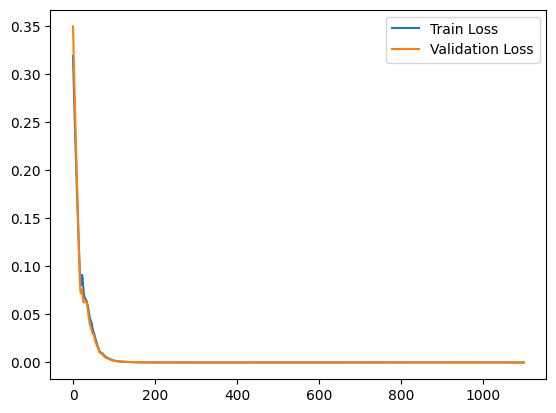

In [27]:
num_epochs = 1100
learning_rate = 0.001

input_size = 1
hidden_size = 64 # need to find correct value; 40 small, 64 norm, 100 a lot
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 0.00


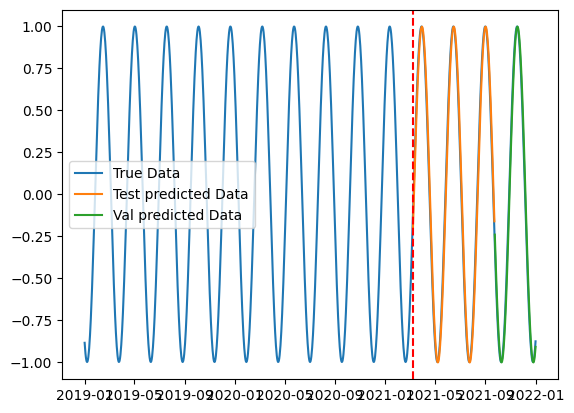

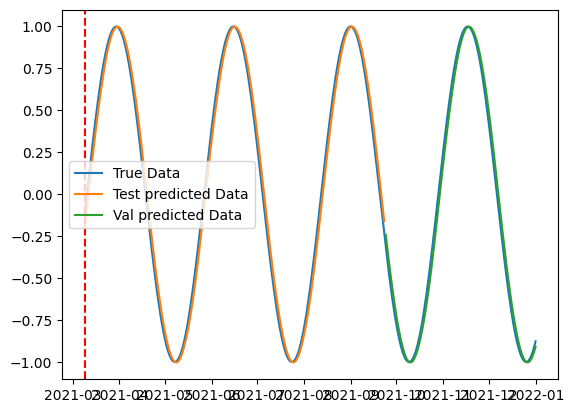

In [29]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(model_data, label='True Data')
plt.plot(model_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(model_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=model_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(model_data.index[-len(predY_test_inv)- val_size:], model_data.Price[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(model_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(model_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=model_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()

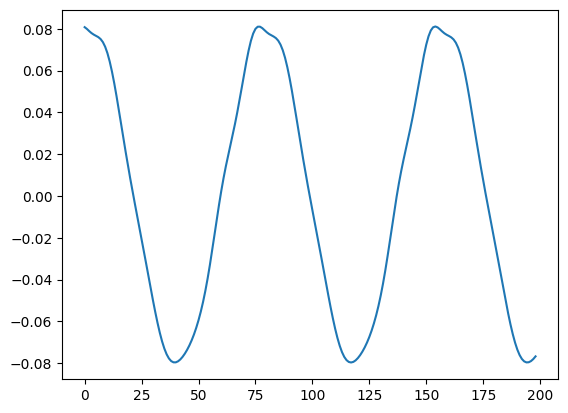

In [30]:
plt.plot(model_data.Price[-len(predY_test_inv)- val_size: - val_size].values - [item for sublist in predY_test_inv for item in sublist])

In [19]:
model_data.Price[-len(predY_test_inv)- val_size: - val_size].values

array([-0.1209545 , -0.04008162,  0.04105513,  0.1219216 ,  0.20198544,
        0.28071957,  0.35760568,  0.43213761,  0.50382471,  0.57219504,
        0.63679851,  0.69720982,  0.75303128,  0.80389541,  0.84946735,
        0.88944711,  0.92357148,  0.95161582,  0.9733955 ,  0.98876716,
        0.99762959,  0.99992446,  0.99563664,  0.98479438,  0.96746905,
        0.9437747 ,  0.91386732,  0.8779438 ,  0.83624062,  0.78903232,
        0.73662968,  0.67937769,  0.61765323,  0.55186265,  0.48243907,
        0.40983951,  0.33454191,  0.25704195,  0.17784985,  0.09748693,
        0.01648223, -0.06463097, -0.14531869, -0.22504975, -0.30329928,
       -0.37955213, -0.45330632, -0.52407632, -0.59139624, -0.65482289,
       -0.71393873, -0.76835459, -0.81771224, -0.86168674, -0.89998861,
       -0.9323657 , -0.95860487, -0.97853338, -0.99202003, -0.99897604,
       -0.99935562, -0.99315627, -0.9804188 , -0.96122706, -0.9357074 ,
       -0.90402782, -0.86639686, -0.82306226, -0.77430931, -0.72